In [67]:
# import libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import StandardScaler

import math

In [68]:
# use GPU
if torch.backends.mps.is_available():
    processor = 'mps'
elif torch.cuda.is_available():
    processor = 'cuda'
else:
    processor = 'cpu'
device = torch.device(processor)
print(device)

mps


If we want to use the GPU processing on a mac we cant use complex tensors, which is a shame, this code involves manually calculating the analytiic formula for the real and imaginary parts, the second cell will only run on the cpu however it takes advantage of the complex tensor builtin. 

In [69]:
class mpsfractal:
    def __init__(self, fractal, device, param = 2, infinity = 8 , constantre = 0 , constantimag = 0):
        # setting the fractal that we are going to be making, this should be a string that is inputted in creation
        self.fractal = fractal 
        # the fil
        self.actual_fractal = 0
        self.device = device
        self.param = param
        self.infinity = infinity
#        self.constant = torch.complex(constantre,constantimag)



    def compute_fractal(self, xmin = -1, xmax = 1, ymin = -1, ymax = 1, w = 3200, h = 2400, maxiter = 256):
        
        x = torch.linspace(xmin, xmax, w, dtype=torch.float,device=self.device).type(torch.half) #w = window's width in pixels; xmin, xmax = left and right borders of the window
        y = torch.linspace(ymin, ymax, h, dtype=torch.float,device=self.device).type(torch.half) #h = window's height in pixels; ymin, ymax = bottom and up borders of the window
        
        #create two tensors, containing respectively all x and y coordinates of all the points in the window. c=[cx,cy]
        cx, cy = torch.meshgrid([x,y])
    
        #set initial value of variable z to zero for the z=z^2+c 
        zx = torch.zeros(w*h, dtype=torch.float32,device=self.device).type(torch.half).resize_as_(cx)
        zy = torch.zeros(w*h, dtype=torch.float32,device=self.device).type(torch.half).resize_as_(cy)
        
        #will represent the color of the pixel, ininitialy 0. Tensor's shape is the same as that of cx, cy, zx and zy
        k = torch.zeros(w*h, dtype=torch.uint8,device=device).reshape(w,h)
        
        for i in range(maxiter):
            zx2 = zx**2 
            zy2 = zy**2
            #escaped is a tensor containing true for all the points that have escaped on the last generation
            escaped = (zx2+zy2)>self.infinity**2 # this is a calculation over all the points to check if they have escaped
            k[escaped] = i #for all the points escaping to infinity, store the number of iteration when that was this discovered
            cx, cy , zx, zy = self.compute_escape(cx,cy,zx,zy,i)
            
        self.actual_fractal = k.t()
    
    def draw(self, smoothing = True, colour= 'hot'):
        if smoothing== True:
            M = self.actual_fractal.cpu()
            scalar = StandardScaler()
            scalar.fit(M)
            M = scalar.fit_transform(M)
        else: 
            M = self.actual_fractal.cpu()
        plt.figure(figsize=(3.200, 2.400), dpi=1000)
        img = plt.imshow(M)
        img.set_cmap(colour)
        plt.axis('off')
        plt.savefig('myfig.png', dpi=1000)
        
    # As of yet pytorch backend for apple silicon does not support complex numbers, therefore to make this work someone has to calculate
    # the symbolic real and imaginary parts of the files manually. I've done if for some of the easier ones but it is unpleasant.
        
    def compute_escape(self, cx,cy,zx,zy,iteration):
        if iteration == 0:
            zx = cx
            zy = cy
        if self.fractal == 'mandelbrot':
            return cx,cy, self.param*(zx**2 -zy**2) + cx , self.param*(2* zx*zy)+ cy
        elif self.fractal == 'sin':
            return cx, cy, zx * (torch.sin(zx)*torch.cosh(zy)) - zy * (torch.cos(zx) * torch.sinh(zy)) ,zy * (torch.sin(zx)*torch.cosh(zy)) + zx * (torch.cos(zx) * torch.sinh(zy))
        elif self.fractal == 'nova':
            return cx,cy, zx - self.param*2*(2*zx**3 - 6*zx*(zy**2)-2)/(3*zx**2-3*zy**2) + cx , zy -self.param * (6*(zy**2) * zy- 2*zy**3 )/(3*zx**2-3*zy**3)+cy
        else: 
            return  cx,cy,zx,zy,
        



In [70]:
mandimps = mpsfractal('mandelbrot', device, 1, 4)
mandimps.compute_fractal(xmin = -3, xmax = 3, ymin = -3, ymax = 3, w = 3200, h = 2400, maxiter = 256)


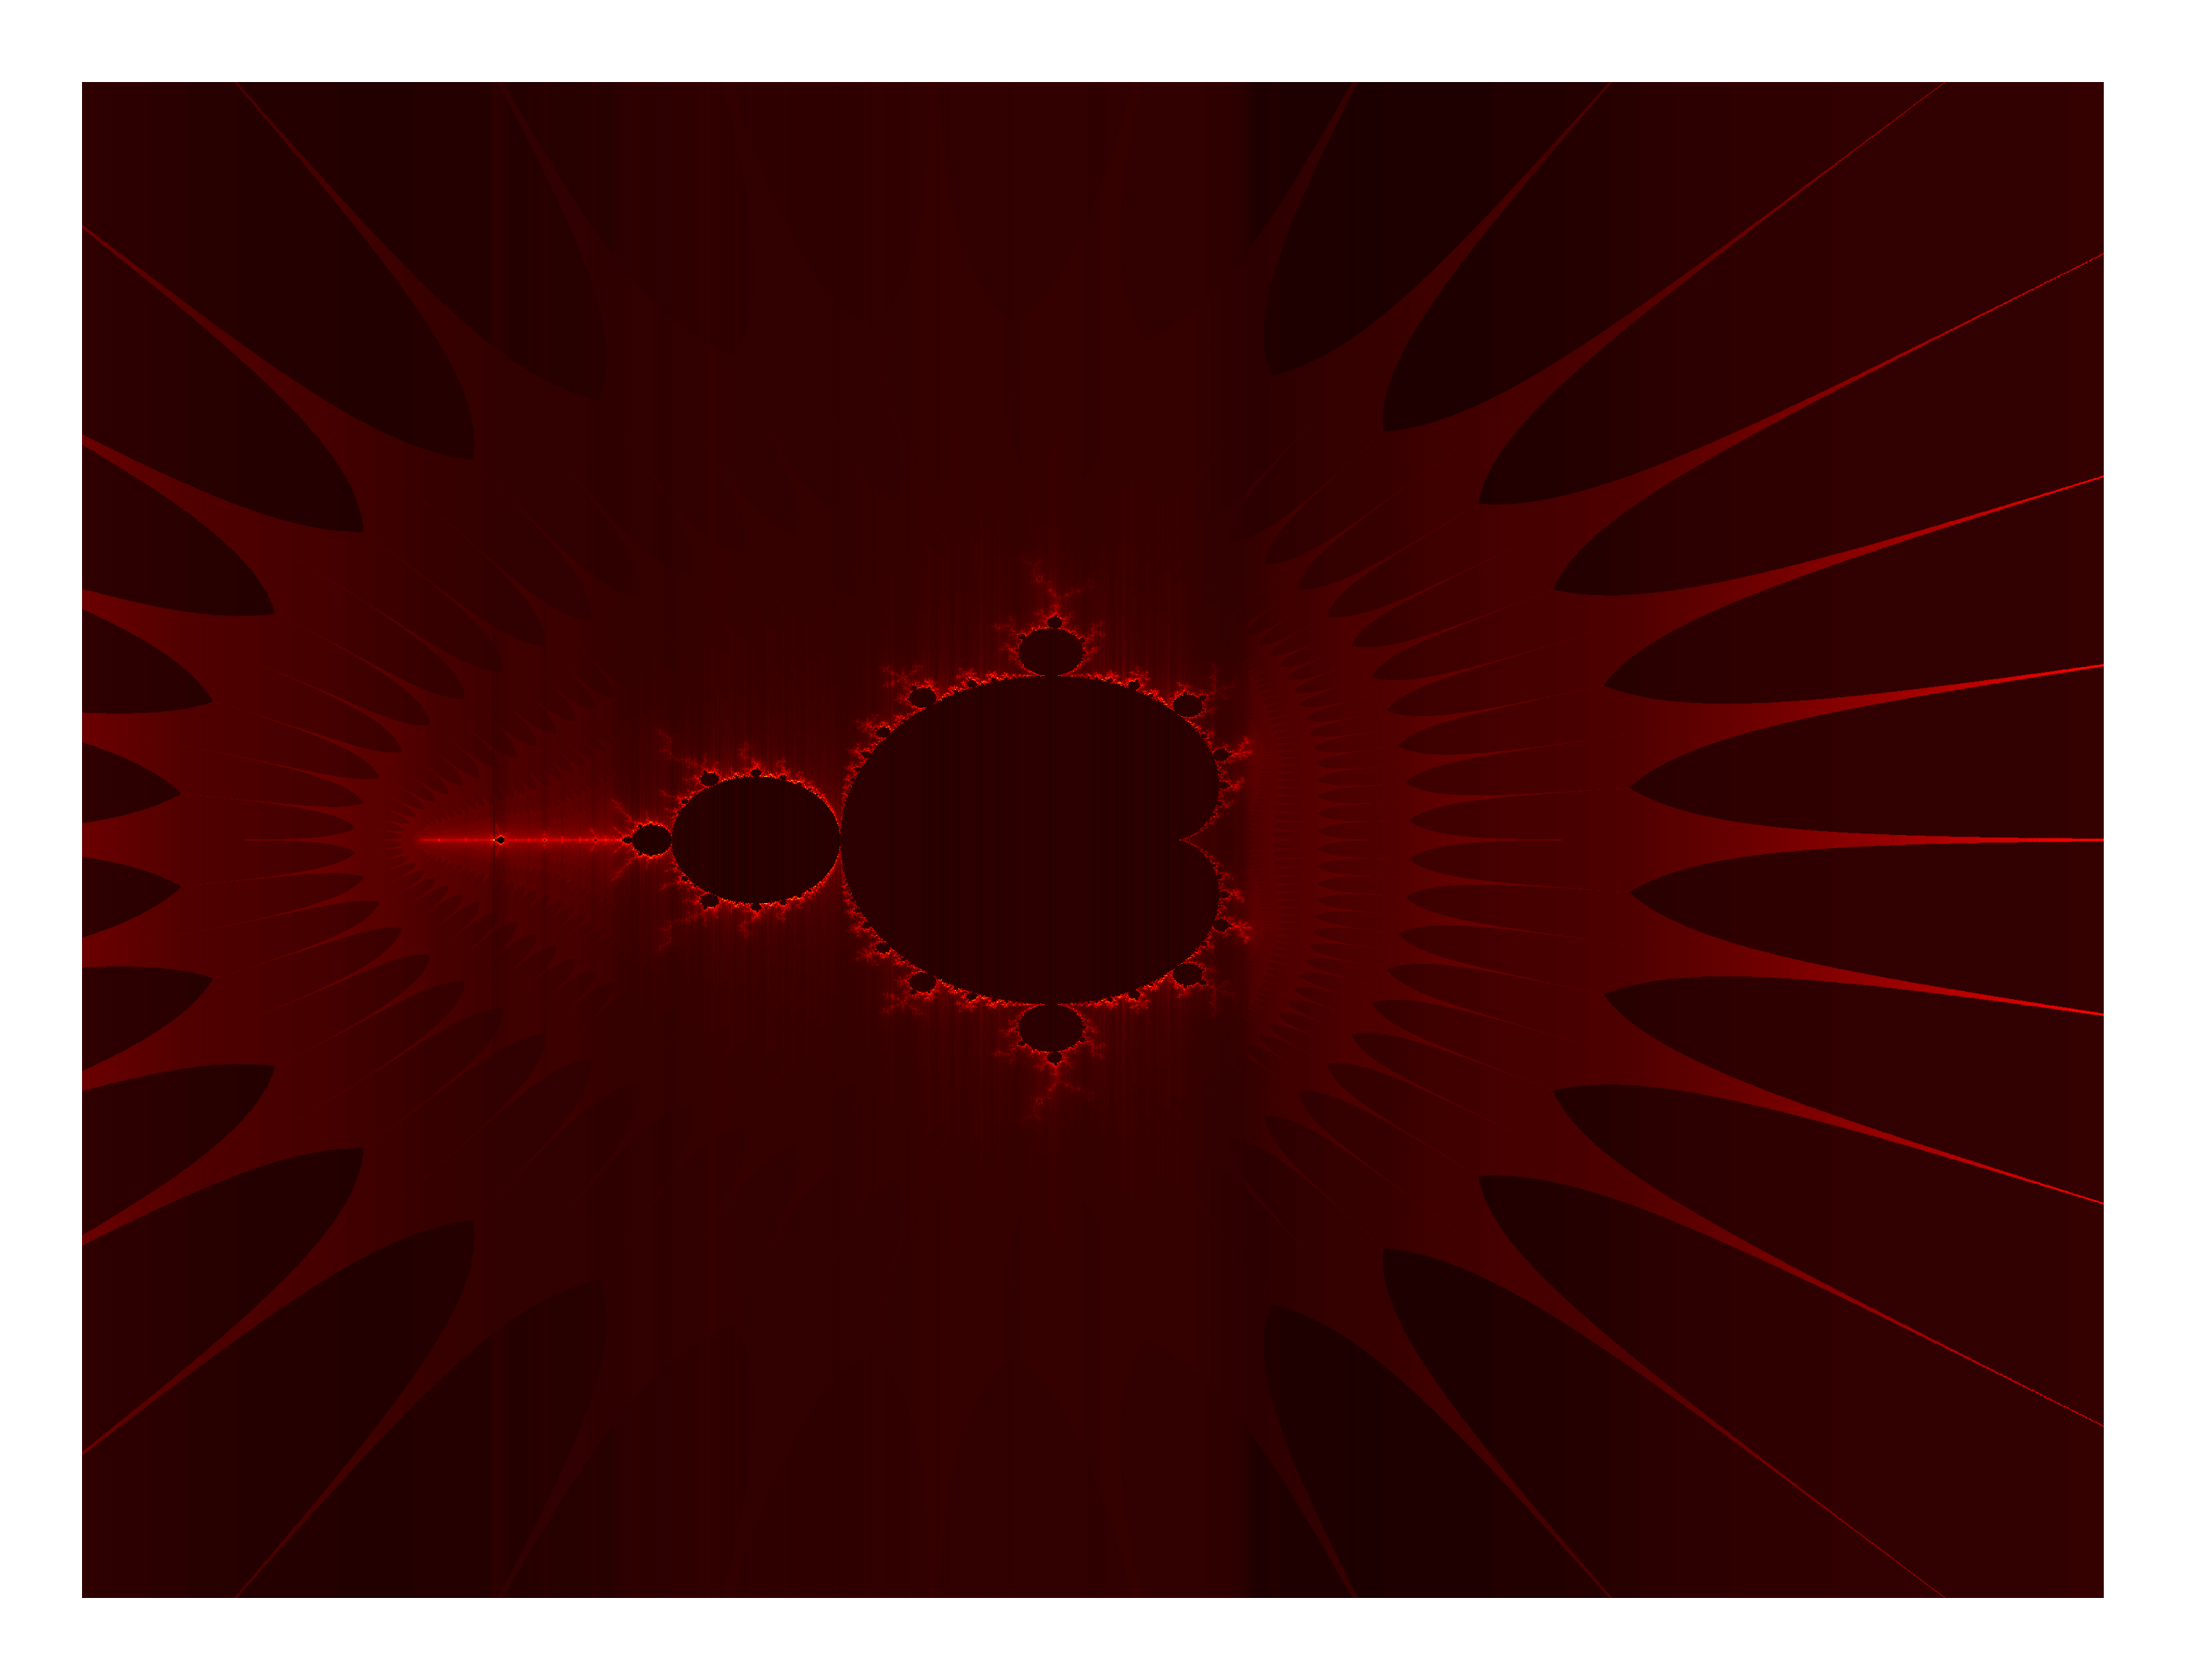

In [71]:
mandimps.draw(smoothing=True, colour = 'hot')

CPU fractal drawing.,if you are running an nvidia GPU this should work with cuda, note the nova and magnet fractal wont work, this is because the feature of complex division has not be impleneted yet. 

In [1]:
class cpufractal:
    def __init__(self, fractal,  device= 'cpu', param = 2, infinity = 8 , constantre = 0 , constantimag = 0):
        # setting the fractal that we are going to be making, this should be a string that is inputted in creation
        self.fractal = fractal 
        # the fil
        self.actual_fractal = 0
        self.device = device
        self.param = param
        self.infinity = infinity
        self.constantre = constantre
        self.constantimag = 1j * constantimag

    def compute_fractal(self, xmin = -1, xmax = 1, ymin = -1, ymax = 1, w = 3200, h = 2400, maxiter = 256):
        
        x = torch.linspace(xmin, xmax, w, dtype=torch.cfloat,device=self.device).type(torch.half) #w = window's width in pixels; xmin, xmax = left and right borders of the window
        y = torch.linspace(ymin, ymax, h, dtype=torch.cfloat,device=self.device).type(torch.half) #h = window's height in pixels; ymin, ymax = bottom and up borders of the window
        
        #create two tensors, containing respectively all x and y coordinates of all the points in the window. c=[cx,cy]
        cx, cy = torch.meshgrid([x,y])
    
        #set initial value of variable z whcih will be the complex number representation of the coordinate
        z = torch.zeros(w*h, dtype=torch.cfloat,device=self.device).type(torch.half).resize_as_(cx)
        
        #will represent the color of the pixel, ininitialy 0. Tensor's shape is the same as that of cx, cy, zx and zy
        k = torch.zeros(w*h, dtype=torch.uint8,device=device).reshape(w,h)
        
        for i in range(maxiter):
            #escaped is a tensor containing true for all the points that have escaped on the last generation
            escaped = (z.abs())>self.infinity**2 # this is a calculation over all the points to check if they have escaped
            k[escaped] = i #for all the points escaping to infinity, store the number of iteration when that was this discovered
            cx, cy , z = self.compute_escape(cx,cy,z,i)
            
        self.actual_fractal = k.t()
    
    def draw(self, smoothing = True, colour = 'hot'):
        if smoothing== True:
            M = self.actual_fractal.cpu()
            scalar = StandardScaler()
            scalar.fit(M)
            M = scalar.fit_transform(M)
        else: 
            M = self.actual_fractal.cpu()
        plt.figure(figsize=(3.200, 2.400), dpi=1000)
        img = plt.imshow(M)
        img.set_cmap(colour)
        plt.axis('off')
        plt.savefig('myfig2.png', dpi=1000)
        
    # As of yet pytorch backend for apple silicon does not support complex numbers, therefore to make this work someone has to calculate
    # the symbolic real and imaginary parts of the files manually. I've done if for some of the easier ones but it is unpleasant.
    # we are going to add a comment using vim here    
    def compute_escape(self, cx,cy,z,iteration):
        if iteration == 0:
            z = torch.complex(cx,cy)
        if self.fractal == 'mandelbrot':
            return cx,cy, z*z+ torch.complex(cx,cy)
        elif self.fractal == 'sin':
            return cx, cy, z * torch.sin(z)
        elif self.fractal == 'nova':
            return cx,cy, z- ((z-1)*(z-1)*(z-1))/(3*z*z) + torch.complex(cx,cy)
        elif self.fractal == 'magnet':
            return cx,cy, torch.sqrt(torch.divide((z*z+torch.complex(cx,cy)-1),(2*z +torch.complex(cx,cy)-2)))
        else:
            return  cx,cy,z

In [73]:
mandigpu = cpufractal('mandelbrot', 'cpu', 1, 4)
mandigpu.compute_fractal(xmin = -3, xmax = 3, ymin = -3, ymax = 3, w = 3200, h = 2400, maxiter = 256)


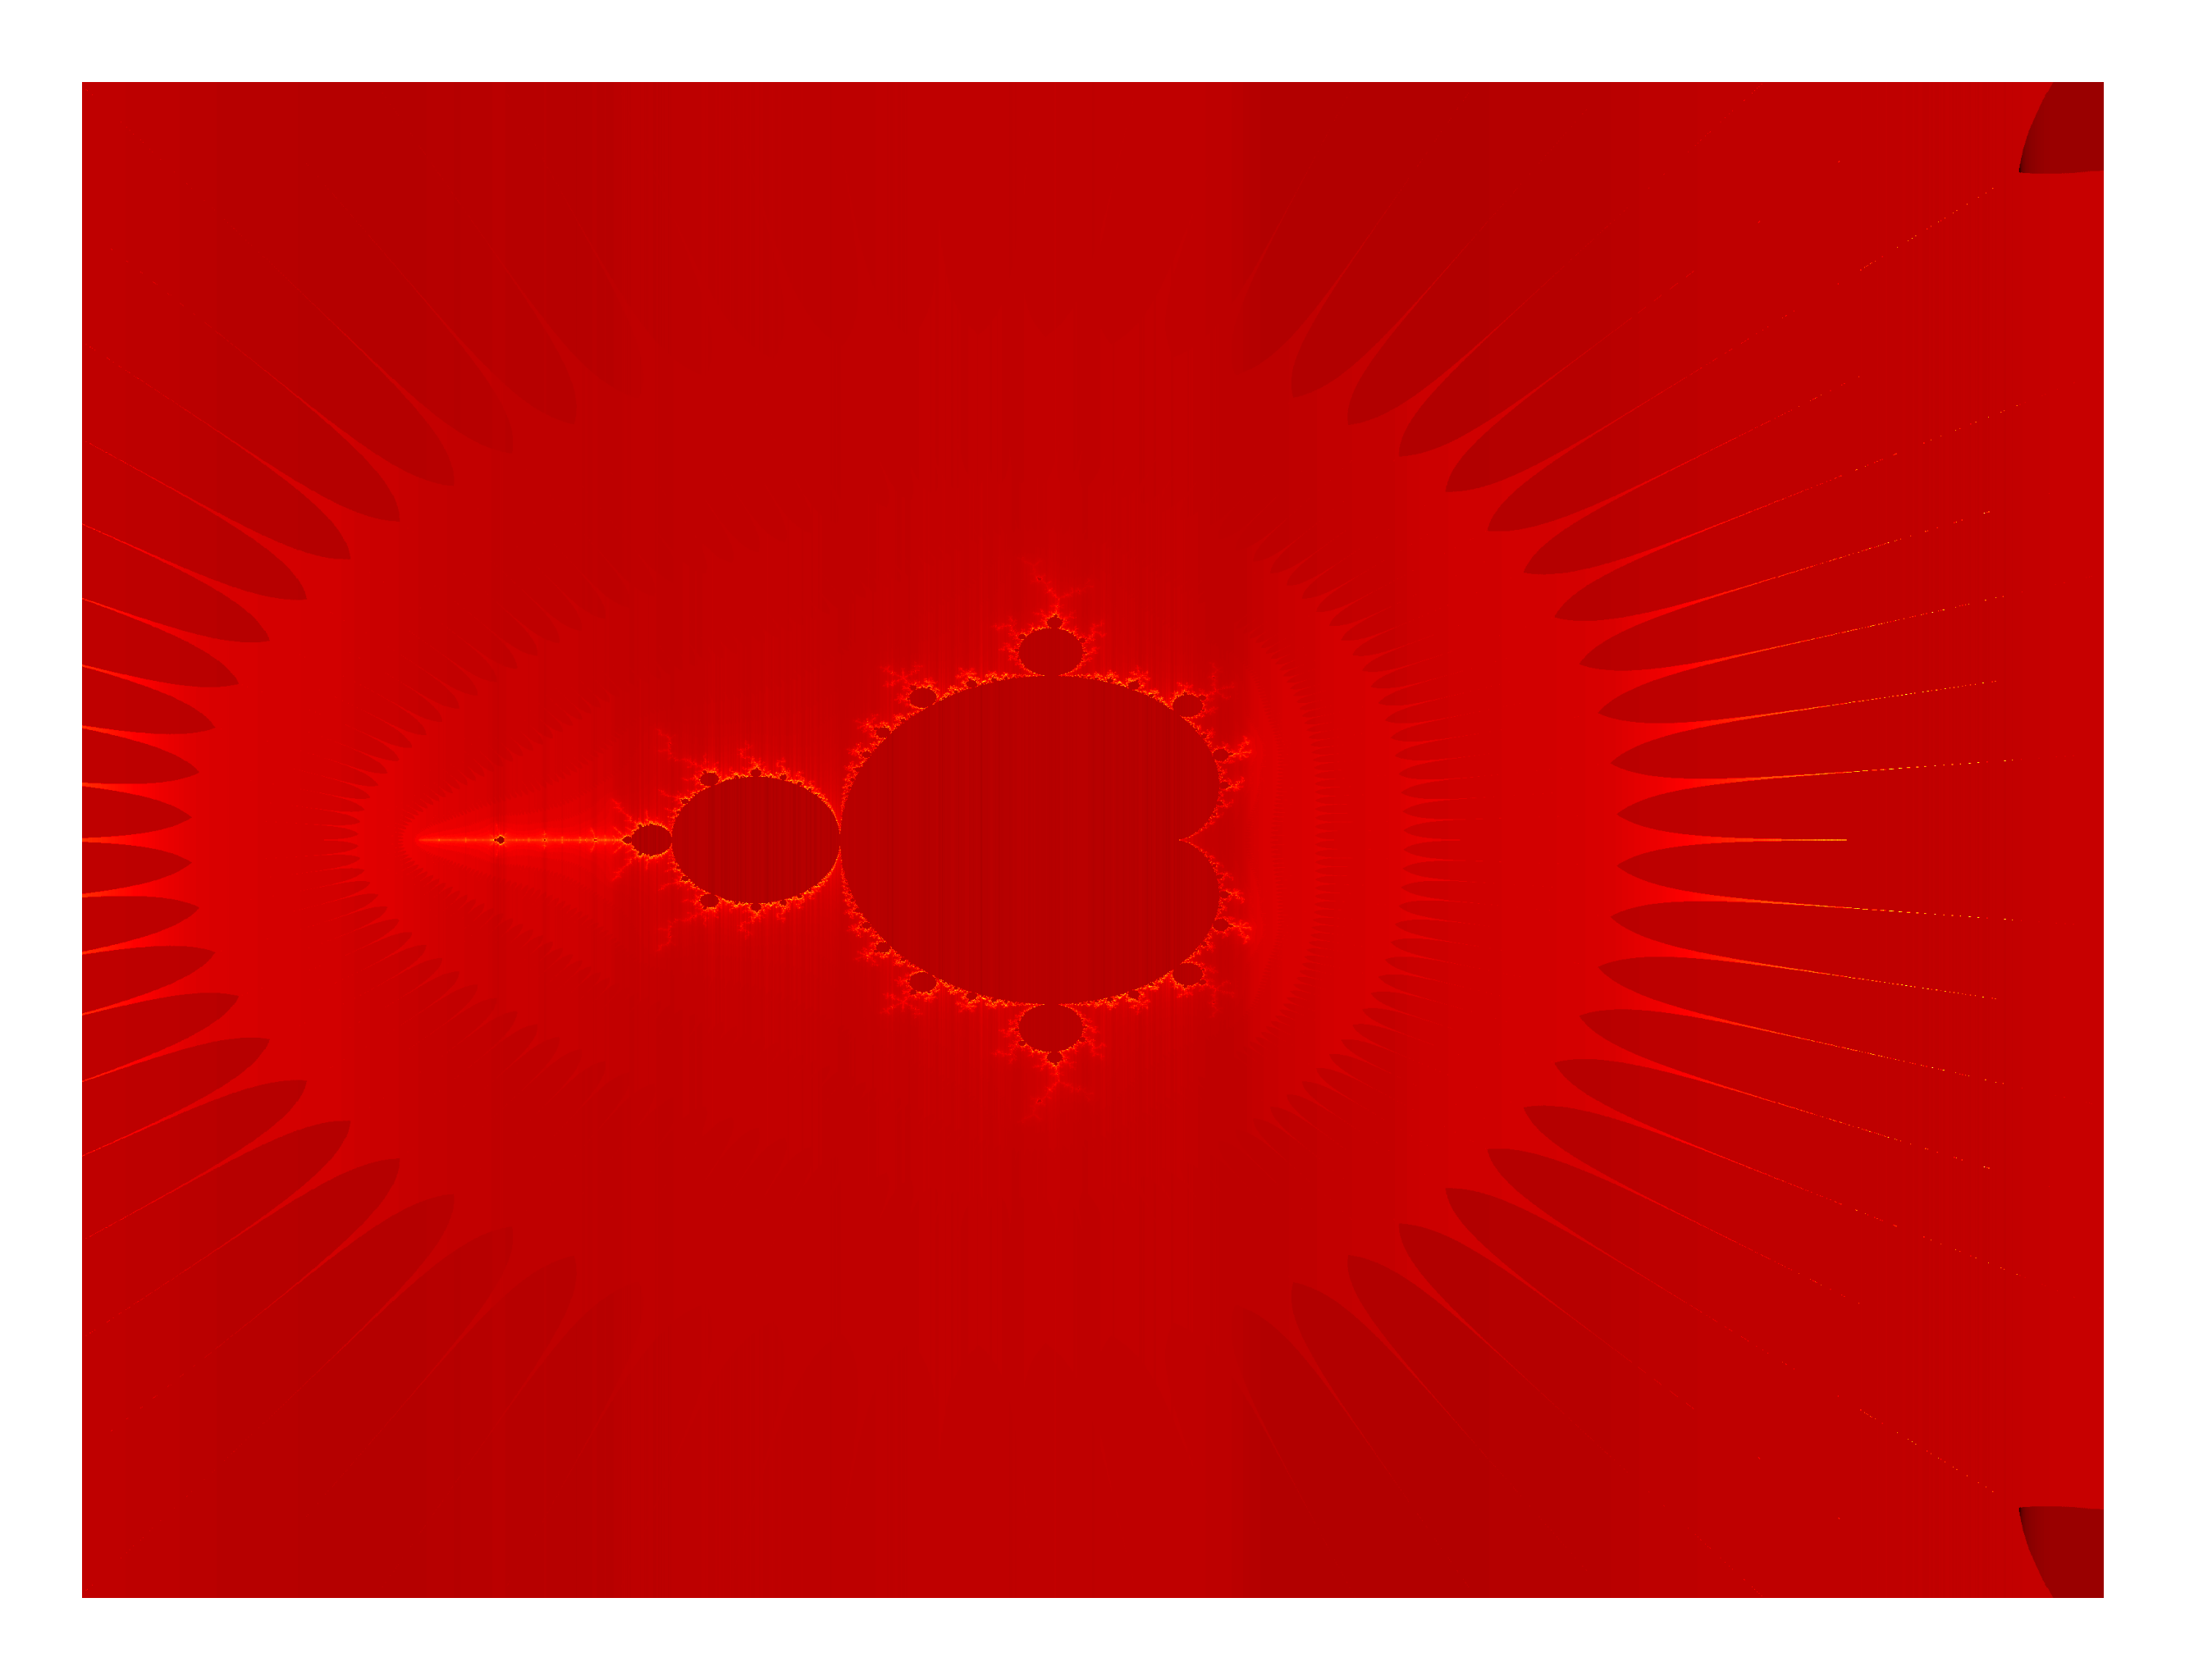

In [74]:
mandigpu.draw(smoothing= True)

In [75]:
class npfractal:
    def __init__(self, fractal, param = 2, infinity = 8 , constantre = 0 , constantimag = 0):
        # setting the fractal that we are going to be making, this should be a string that is inputted in creation
        self.fractal = fractal 
        # The colour scheme used in plotting
        # the fil
        self.actual_fractal = 0
        self.param = param
        self.infinity = infinity
        self.constantre = constantre
        self.constantimag = 1j * constantimag

    def compute_fractal(self, xmin = -1, xmax = 1, ymin = -1, ymax = 1, w = 3200, h = 2400, maxiter = 256):
        
        x = np.linspace(xmin, xmax, w) #w = window's width in pixels; xmin, xmax = left and right borders of the window
        y = np.linspace(ymin, ymax, h ) #h = window's height in pixels; ymin, ymax = bottom and up borders of the window
        
        #create two tensors, containing respectively all x and y coordinates of all the points in the window. c=[cx,cy]
        cx, cy = np.meshgrid(x,y)
    
        #set initial value of variable z whcih will be the complex number representation of the coordinate
        z = np.zeros([h,w])
        
        #will represent the color of the pixel, ininitialy 0. Tensor's shape is the same as that of cx, cy, zx and zy
        k = np.zeros([h,w])
        
        for i in range(maxiter):
            #escaped is a tensor containing true for all the points that have escaped on the last generation
            escaped = (z.real**2 + z.imag**2)>self.infinity # this is a calculation over all the points to check if they have escaped
            k[escaped] = i #for all the points escaping to infinity, store the number of iteration when that was this discovered
            cx, cy , z = self.compute_escape(cx,cy,z,i)
            
        self.actual_fractal = k
    
    def draw(self, smoothing = True, colour = 'cool'):
        if smoothing== True:
            M = self.actual_fractal
            scalar = StandardScaler()
            scalar.fit(M)
            M = scalar.fit_transform(M)
        else: 
            M = self.actual_fractal
        plt.figure(figsize=(3.200, 2.400), dpi=1000)
        img = plt.imshow(M)
        img.set_cmap(colour)
        plt.axis('off')
        plt.savefig('myfig3.png', dpi=1000)
        
    # As of yet pytorch backend for apple silicon does not support complex numbers, therefore to make this work someone has to calculate
    # the symbolic real and imaginary parts of the files manually. I've done if for some of the easier ones but it is unpleasant.
        
    def compute_escape(self, cx,cy,z,iteration):
        if iteration == 0:
            z = cx + 1j*cy
        if self.fractal == 'mandelbrot':
            return cx,cy, z*z+ cx + 1j*cy
        elif self.fractal == 'sin':
            return cx, cy, z * np.sin(z)
        elif self.fractal == 'nova':
            return cx,cy, z - ((z-1)*(z-1)*(z-1))/(3*z*z) + cx + 1j*cy#self.constantimag + self.constantimag
        elif self.fractal == 'magnet':
            return cx,cy, np.sqrt((z*z+self.constantimag + self.constantimag -1)/(2*z +self.constantimag + self.constantimag-2))
        else:
            return  cx,cy,z


In [88]:
mandi = npfractal('nova', 1 , 10 , constantre = 0, constantimag=0)
mandi.compute_fractal(xmin = -0.05, xmax = 0.05, ymin = -0.05, ymax = 0.05, w = 3200, h = 2400, maxiter = 256)


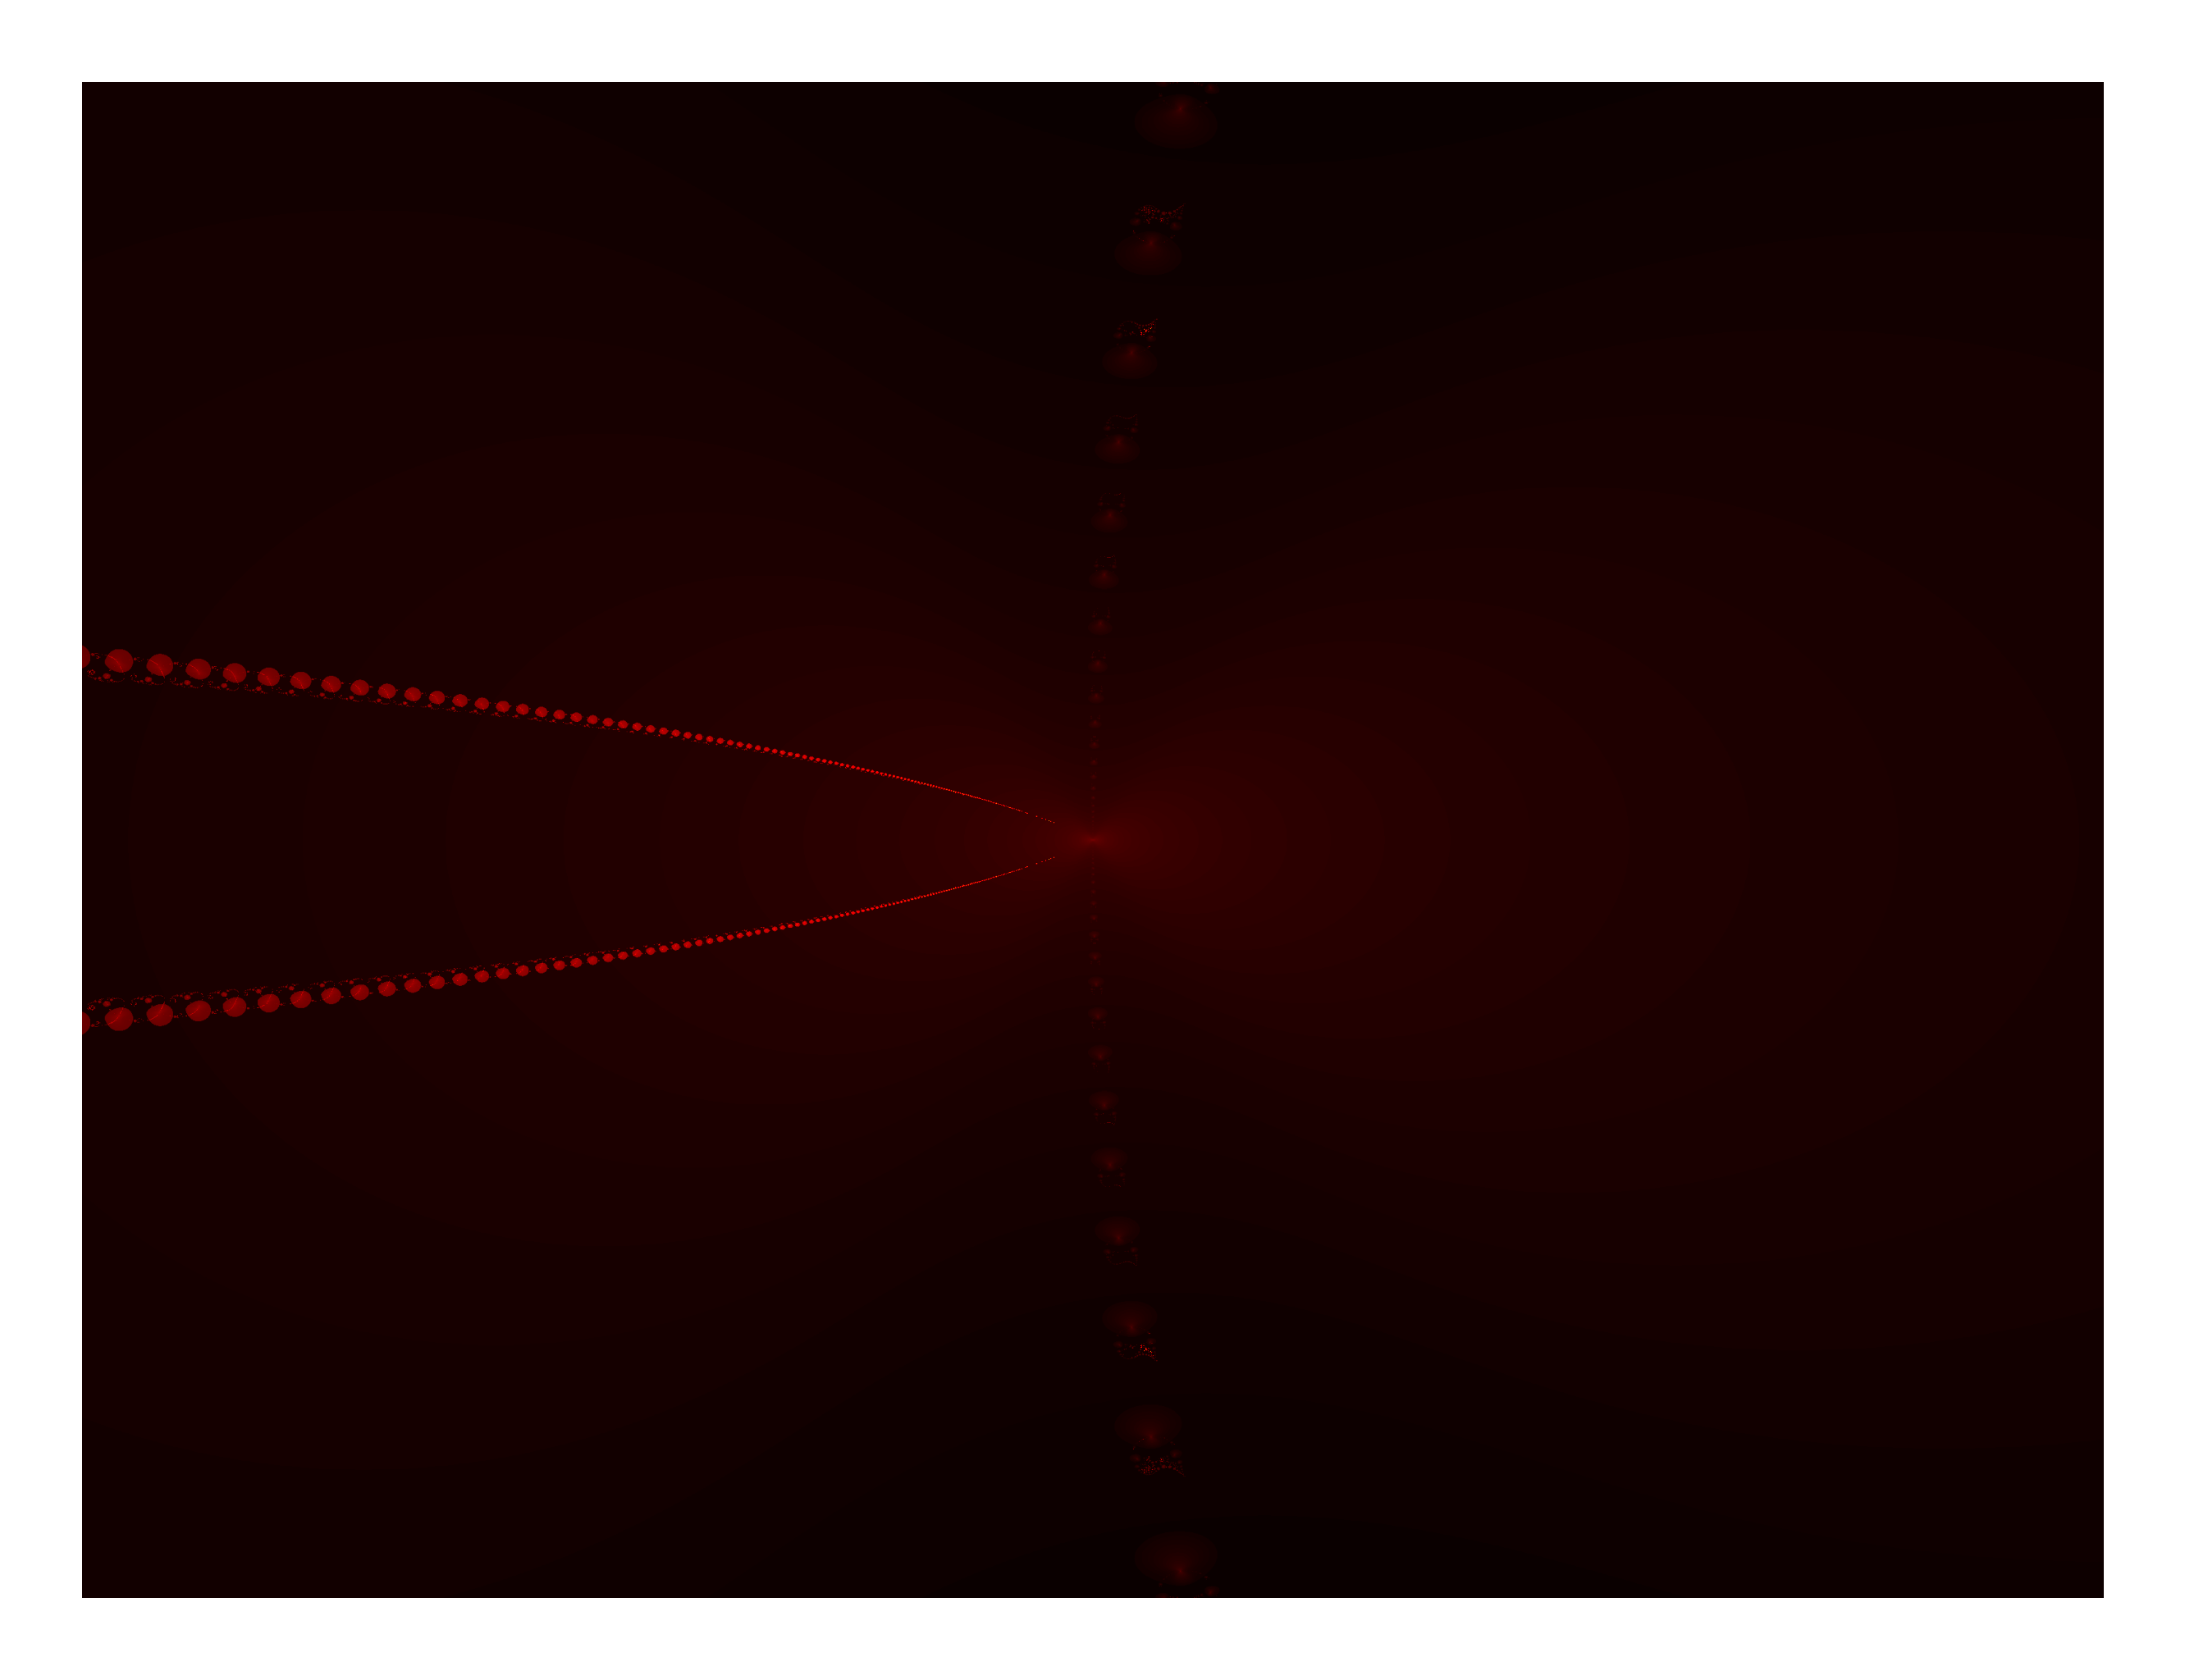

In [89]:
mandi.draw(smoothing=False, colour = 'hot')